In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

# Perceptrons

In [46]:
iris = load_iris()
x = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(random_state=42)
per_clf.fit(x, y)

y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1])

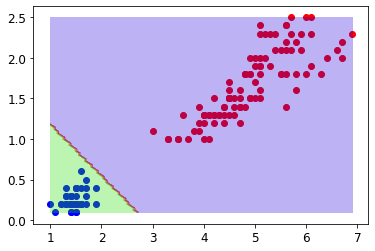

In [49]:
plt.scatter(x[y==0][:, 0], x[y==0][:, 1], c='r')
plt.scatter(x[y==1][:, 0], x[y==1][:, 1], c='b')

xx = np.linspace(np.min(x[:, 0]), np.max(np.max(x[:, 0])), 100)
yy = np.linspace(np.min(x[:, 1]), np.max(np.max(x[:, 1])), 100)

xs, ys = np.meshgrid(xx, yy)
x_new = np.c_[xs.ravel(), ys.ravel()]
y_new = per_clf.predict(x_new).reshape(xs.shape)

plt.contourf(xs, ys, y_new, cmap=plt.cm.brg, alpha=0.3)
plt.show()

# Implementing MLPs with Keras

In [61]:
import tensorflow as tf
from tensorflow import keras

'tensorflow', tf.__version__, 'keras', keras.__version__

('tensorflow', '2.1.0', 'keras', '2.2.4-tf')

### Image Classifier  

In [63]:
fashion_mnist = keras.datasets.fashion_mnist

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [69]:
X_train_full.shape, X_train_full.dtype

((60000, 28, 28), dtype('uint8'))

In [72]:
X_train, y_train = X_train_full[:50000], y_train_full[:50000]
X_valid, y_valid = X_train_full[50000:], y_train_full[50000:]

In [85]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [96]:
def plot_mnist(data, labels, n_cols=5):
    n_rows = (len(data) - 1) // n_cols + 1
    plt.figure(figsize=(1.5*n_cols, 1.5*n_rows))
    for index, (face, label) in enumerate(zip(data, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(class_names[label])
    plt.show()

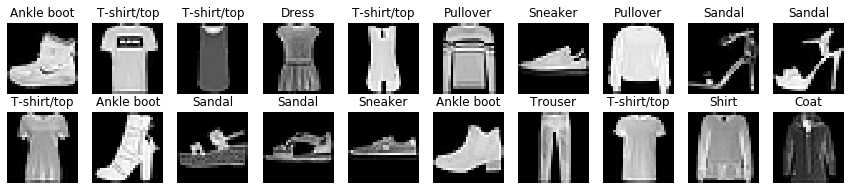

In [101]:
plot_mnist(X_train_full[:20], y_train_full[:20], 10)

**review Sequential API**

Нейросеть с 2я скрытыми слоями

In [103]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

layers can be added this way

In [104]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [105]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.layers

In [108]:
model.layers[1].name

'dense_3'

In [109]:
model.get_layer('dense_3').name

'dense_3'

In [111]:
weights, biases = model.get_layer('dense_3').get_weights()

In [114]:
print(weights.shape)
print(biases.shape)

(784, 300)
(300,)
